# Heterotic Orbiencoder

A deep autoencoder is a feedforward NN, mainly used to dimensionally
reduce or compress some complex high dimensional data. It is built by two components: the 
encoder and the decoder. The purpose of the encoder is to identify and reduce the 
redundancies (and noise) of input data defined by a large number of parameters, lowering 
step-wise in various (hidden) layers the dimensionality of the parameter space. If the encoder is 
deep enough, i.e. if it has a large number of layers, and the data is adequate, its 
capability to encode the input data into a small number of parameters tends to improve. 
The last layer of the encoder is known as the (central) *latent layer* or latent-space 
representation, and it contains a "compressed code" of the input data, represented in 
a small number of parameters. The decoder operates inversely to the encoder, reconstructing 
the data from the latent layer back to its original higher dimensional form. One can define the 
accuracy of an autoencoder as the level of likeness between the output resulting
from the decoder and the corresponding original information in the input layer.

Given some input data, one must choose an autoencoder *configuration* that
maximizes the accuracy of the algorithm. The properties that describe an autoencoder
configuration are:

* **Topology**: overall structure that defines the way the neurons of the NN
  are connected among different layers. The topology can be symmetric or asymmetric with 
  respect to the latent or bottleneck layer, fully or partly connected, and can include convolutional 
  layers or other types of substructures. We avoid convolutional or other complex layers
  for simplicity.

* **Architecture**: number of layers and number of neurons per layer (layer size). In the case of
  an autoencoder, it includes the sizes of all hidden layers of the encoder and decoder,
  the input and output layers, as well as the size of the latent layer.

* **Initial weight distribution**: the values of the trainable parameters or weights that 
  characterize the neurons must be initialized at random values using a method that 
  may be useful to arrive at the best accuracy; it is customary to take a Gaussian or 
  uniform distribution, but other options (such as Xavier or He initializations) 
  are possible.

* **Activation function**: together with a bias, it defines the output of a neuron 
  given some input information; it adds some non-linearity to the learning process in
  order to improve it. Some examples that we shall use in this work include Leaky-ReLU, 
  Softplus, ELU, CELU, ReLU, SELU, Hardtanh, Softmax and LogSigmoid 
  for details of activation functions).
  In principle, every layer can have a different activation function, but we apply homogeneously 
  the same activation function to all layers for simplicity.

* **Loss function**: evaluation during the training stage that determines the magnitude of
  the inaccuracy that the NN has achieved before updating the weights of the
  network.
  Some examples of loss functions used in this paper are Cross Entropy (CE), SmoothL1, 
  MSE, Huber, BCEWL, L1 and Hinge Embedding.

* **Optimizer**: optimization algorithm used to minimize the loss; some examples applied in this
  work are Adam, AdamW, Adamax, RMSProp, Adagrad, Adadelta, SGD and ASGD.

* **Number of epochs**: number of times that the algorithm is run to improve the 
  learning skills of the algorithm, trying to minimize the error.

* **Batch size**: for each epoch, it is the number of samples in which the training input
  data is split in order to have several training subsets. Typically, large batch sizes
  lead to better statistical characterizations; however, one must choose the size that
  best helps to maximize the accuracy of the algorithm.

* **Shuffling**: to optimize the learning process, whether or not the elements contained 
  in each batch, per epoch are randomly shuffled. 

* **Dropout**: if applied, it defines the number of dropout layers and the fraction of neurons that are 
  randomly dropped out; this is typically used with the goal of reducing overfitting.


## Dependences

In [14]:
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import data as data
import routines as routines
import utils as utils

## Setup

### Neural Network

The NN implemented is fully connected and symmetrical. The dimensions array has the ordered number 
of neurons per layer. All the layers are set with *leaky_relu* as the activation function. The Autoencoder is
segmented in two sections because the encoding and decoding elements are required individually in further
sections.

In [15]:
class Net(nn.Module):

    def __init__(self, dimensions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(dimensions[0], dimensions[1])
        self.fc2 = nn.Linear(dimensions[1], dimensions[2])
        self.fc3 = nn.Linear(dimensions[2], dimensions[3])
        self.fc4 = nn.Linear(dimensions[3], dimensions[4])
        self.fc5 = nn.Linear(dimensions[4], dimensions[5])

        self.fc6 = nn.Linear(dimensions[5], dimensions[6])
        self.fc7 = nn.Linear(dimensions[6], dimensions[7])
        self.fc8 = nn.Linear(dimensions[7], dimensions[8])
        self.fc9 = nn.Linear(dimensions[8], dimensions[9])
        self.fc10 = nn.Linear(dimensions[9], dimensions[10])

    def encode(self, Layer):
        Layer = F.leaky_relu(self.fc1(Layer))
        Layer = F.leaky_relu(self.fc2(Layer))
        Layer = F.leaky_relu(self.fc3(Layer))
        Layer = F.leaky_relu(self.fc4(Layer))
        Layer = F.leaky_relu(self.fc5(Layer))
        return Layer

    def decode(self, Layer):
        Layer = F.leaky_relu(self.fc6(Layer))
        Layer = F.leaky_relu(self.fc7(Layer))
        Layer = F.leaky_relu(self.fc8(Layer))
        Layer = F.leaky_relu(self.fc9(Layer))
        Layer = F.leaky_relu(self.fc10(Layer))
        return Layer

    def forward(self, Layer):
        return self.decode(self.encode(Layer))

### Parameters

In this section several input variables can be set.

In [16]:
# Name input dataset
datasetname = './data/600K_Z8-Z12.csv'

# ohe and features lenghts
lenghts_data = data.lenghts_features(datasetname) 
l_ohe = sum(lenghts_data)

# latent space dimension
latent = 3

# Dimensions of layers 
dimensions = [l_ohe, 2*l_ohe, 200, 26, 13, latent, 13, 26, 200, 2*l_ohe, l_ohe]

# Number of epochs for training
epochs = 1010
# Save every num of epochs
save_each_epoch = 100


# Parameters for dataset train
# Ration of the dataset to be trained
train_set = 0.6
# Seed to be set for the reproducibility of the model
seed = 1
# A high value for the batchsize is recommended, although it may be changed to fit the PC capabilities
batchsize = 32
# Number of processed used on CPU to mount on GPU
workers = 8

# label train log
label = "1010_e_leaky"

### Instantiation

In [17]:
# Parameters parsing
parameters = {"datasetname":datasetname,
             "seed":1,
             "epochs": epochs,
             "train_set": train_set,
             "batchsize": batchsize,
             "workers": workers,
             "label":label,
             "lenghts_data":lenghts_data,
             "latent": latent,
             "save_each_epoch":save_each_epoch}

# Model instantiation
model = Net(dimensions)
# Definition of loss function
criterion = nn.CrossEntropyLoss()
# Definition of optimizer & learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Scheduler set
scheduler = lr_scheduler.StepLR(optimizer, step_size= 4000, gamma=0.1)

## Training

In [ ]:
%%time
# Start training
routines.train(model, criterion, optimizer, scheduler, **parameters)

Preparing data
Using GPU
Start training
--------------------------------------------------
Epoch 1/1010
train Loss: 1.0452 Acc: 8.0523
Epoch 1/1010
valid Loss: 0.8777 Acc: 9.6142
--------------------------------------------------
Epoch 2/1010
train Loss: 0.8374 Acc: 10.0859
Epoch 2/1010
valid Loss: 0.8000 Acc: 10.5336
--------------------------------------------------
Epoch 3/1010
train Loss: 0.7776 Acc: 10.7821
Epoch 3/1010
valid Loss: 0.7605 Acc: 10.9303
--------------------------------------------------
Epoch 4/1010
train Loss: 0.7469 Acc: 11.1378
Epoch 4/1010
valid Loss: 0.7382 Acc: 11.2671
--------------------------------------------------
Epoch 5/1010
train Loss: 0.7255 Acc: 11.4003
Epoch 5/1010
valid Loss: 0.7193 Acc: 11.4920
--------------------------------------------------
Epoch 6/1010
train Loss: 0.7082 Acc: 11.6050
Epoch 6/1010
valid Loss: 0.7019 Acc: 11.6951
--------------------------------------------------
Epoch 7/1010
train Loss: 0.6935 Acc: 11.7731
Epoch 7/1010
valid L

Epoch 58/1010
train Loss: 0.5325 Acc: 13.7541
Epoch 58/1010
valid Loss: 0.5497 Acc: 13.5967
--------------------------------------------------
Epoch 59/1010
train Loss: 0.5315 Acc: 13.7657
Epoch 59/1010
valid Loss: 0.5445 Acc: 13.6674
--------------------------------------------------
Epoch 60/1010
train Loss: 0.5304 Acc: 13.7817
Epoch 60/1010
valid Loss: 0.5437 Acc: 13.6659
--------------------------------------------------
Epoch 61/1010
train Loss: 0.5293 Acc: 13.7907
Epoch 61/1010
valid Loss: 0.5455 Acc: 13.6670
--------------------------------------------------
Epoch 62/1010
train Loss: 0.5284 Acc: 13.8050
Epoch 62/1010
valid Loss: 0.5612 Acc: 13.4735
--------------------------------------------------
Epoch 63/1010
train Loss: 0.5275 Acc: 13.8165
Epoch 63/1010
valid Loss: 0.5427 Acc: 13.6971
--------------------------------------------------
Epoch 64/1010
train Loss: 0.5265 Acc: 13.8310
Epoch 64/1010
valid Loss: 0.5426 Acc: 13.6893
--------------------------------------------------

Epoch 115/1010
valid Loss: 0.5161 Acc: 14.0542
--------------------------------------------------
Epoch 116/1010
train Loss: 0.4892 Acc: 14.2947
Epoch 116/1010
valid Loss: 0.5164 Acc: 14.0579
--------------------------------------------------
Epoch 117/1010
train Loss: 0.4888 Acc: 14.2983
Epoch 117/1010
valid Loss: 0.5192 Acc: 14.0392
--------------------------------------------------
Epoch 118/1010
train Loss: 0.4884 Acc: 14.3019
Epoch 118/1010
valid Loss: 0.5216 Acc: 14.0018
--------------------------------------------------
Epoch 119/1010
train Loss: 0.4877 Acc: 14.3148
Epoch 119/1010
valid Loss: 0.5157 Acc: 14.0549
--------------------------------------------------
Epoch 120/1010
train Loss: 0.4874 Acc: 14.3141
Epoch 120/1010
valid Loss: 0.5160 Acc: 14.0713
--------------------------------------------------
Epoch 121/1010
train Loss: 0.4868 Acc: 14.3225
Epoch 121/1010
valid Loss: 0.5124 Acc: 14.1151
--------------------------------------------------
Epoch 122/1010
train Loss: 0.486

Epoch 172/1010
train Loss: 0.4668 Acc: 14.5790
Epoch 172/1010
valid Loss: 0.5076 Acc: 14.2147
--------------------------------------------------
Epoch 173/1010
train Loss: 0.4665 Acc: 14.5806
Epoch 173/1010
valid Loss: 0.5020 Acc: 14.2984
--------------------------------------------------
Epoch 174/1010
train Loss: 0.4662 Acc: 14.5867
Epoch 174/1010
valid Loss: 0.4967 Acc: 14.3510
--------------------------------------------------
Epoch 175/1010
train Loss: 0.4657 Acc: 14.5930
Epoch 175/1010
valid Loss: 0.5028 Acc: 14.2731
--------------------------------------------------
Epoch 176/1010
train Loss: 0.4656 Acc: 14.5929
Epoch 176/1010
valid Loss: 0.4979 Acc: 14.3540
--------------------------------------------------
Epoch 177/1010
train Loss: 0.4654 Acc: 14.5968
Epoch 177/1010
valid Loss: 0.4979 Acc: 14.3350
--------------------------------------------------
Epoch 178/1010
train Loss: 0.4649 Acc: 14.6017
Epoch 178/1010
valid Loss: 0.5071 Acc: 14.2172
------------------------------------

## Reporting


The output files will be saved in directories:
* savedModels
* reports

### Loss and accuracy

In [5]:
# Visualize list of reports
!ls reports

log_loss_accuracy-1010_e_leaky	log_loss_accuracy-1_e_leaky


All the reports are in the format *log__loss_accuracy*-label. 
The label has to be provided for the plots to be generated, 
i.e. 1_e_leaky has to be provided in the previous case

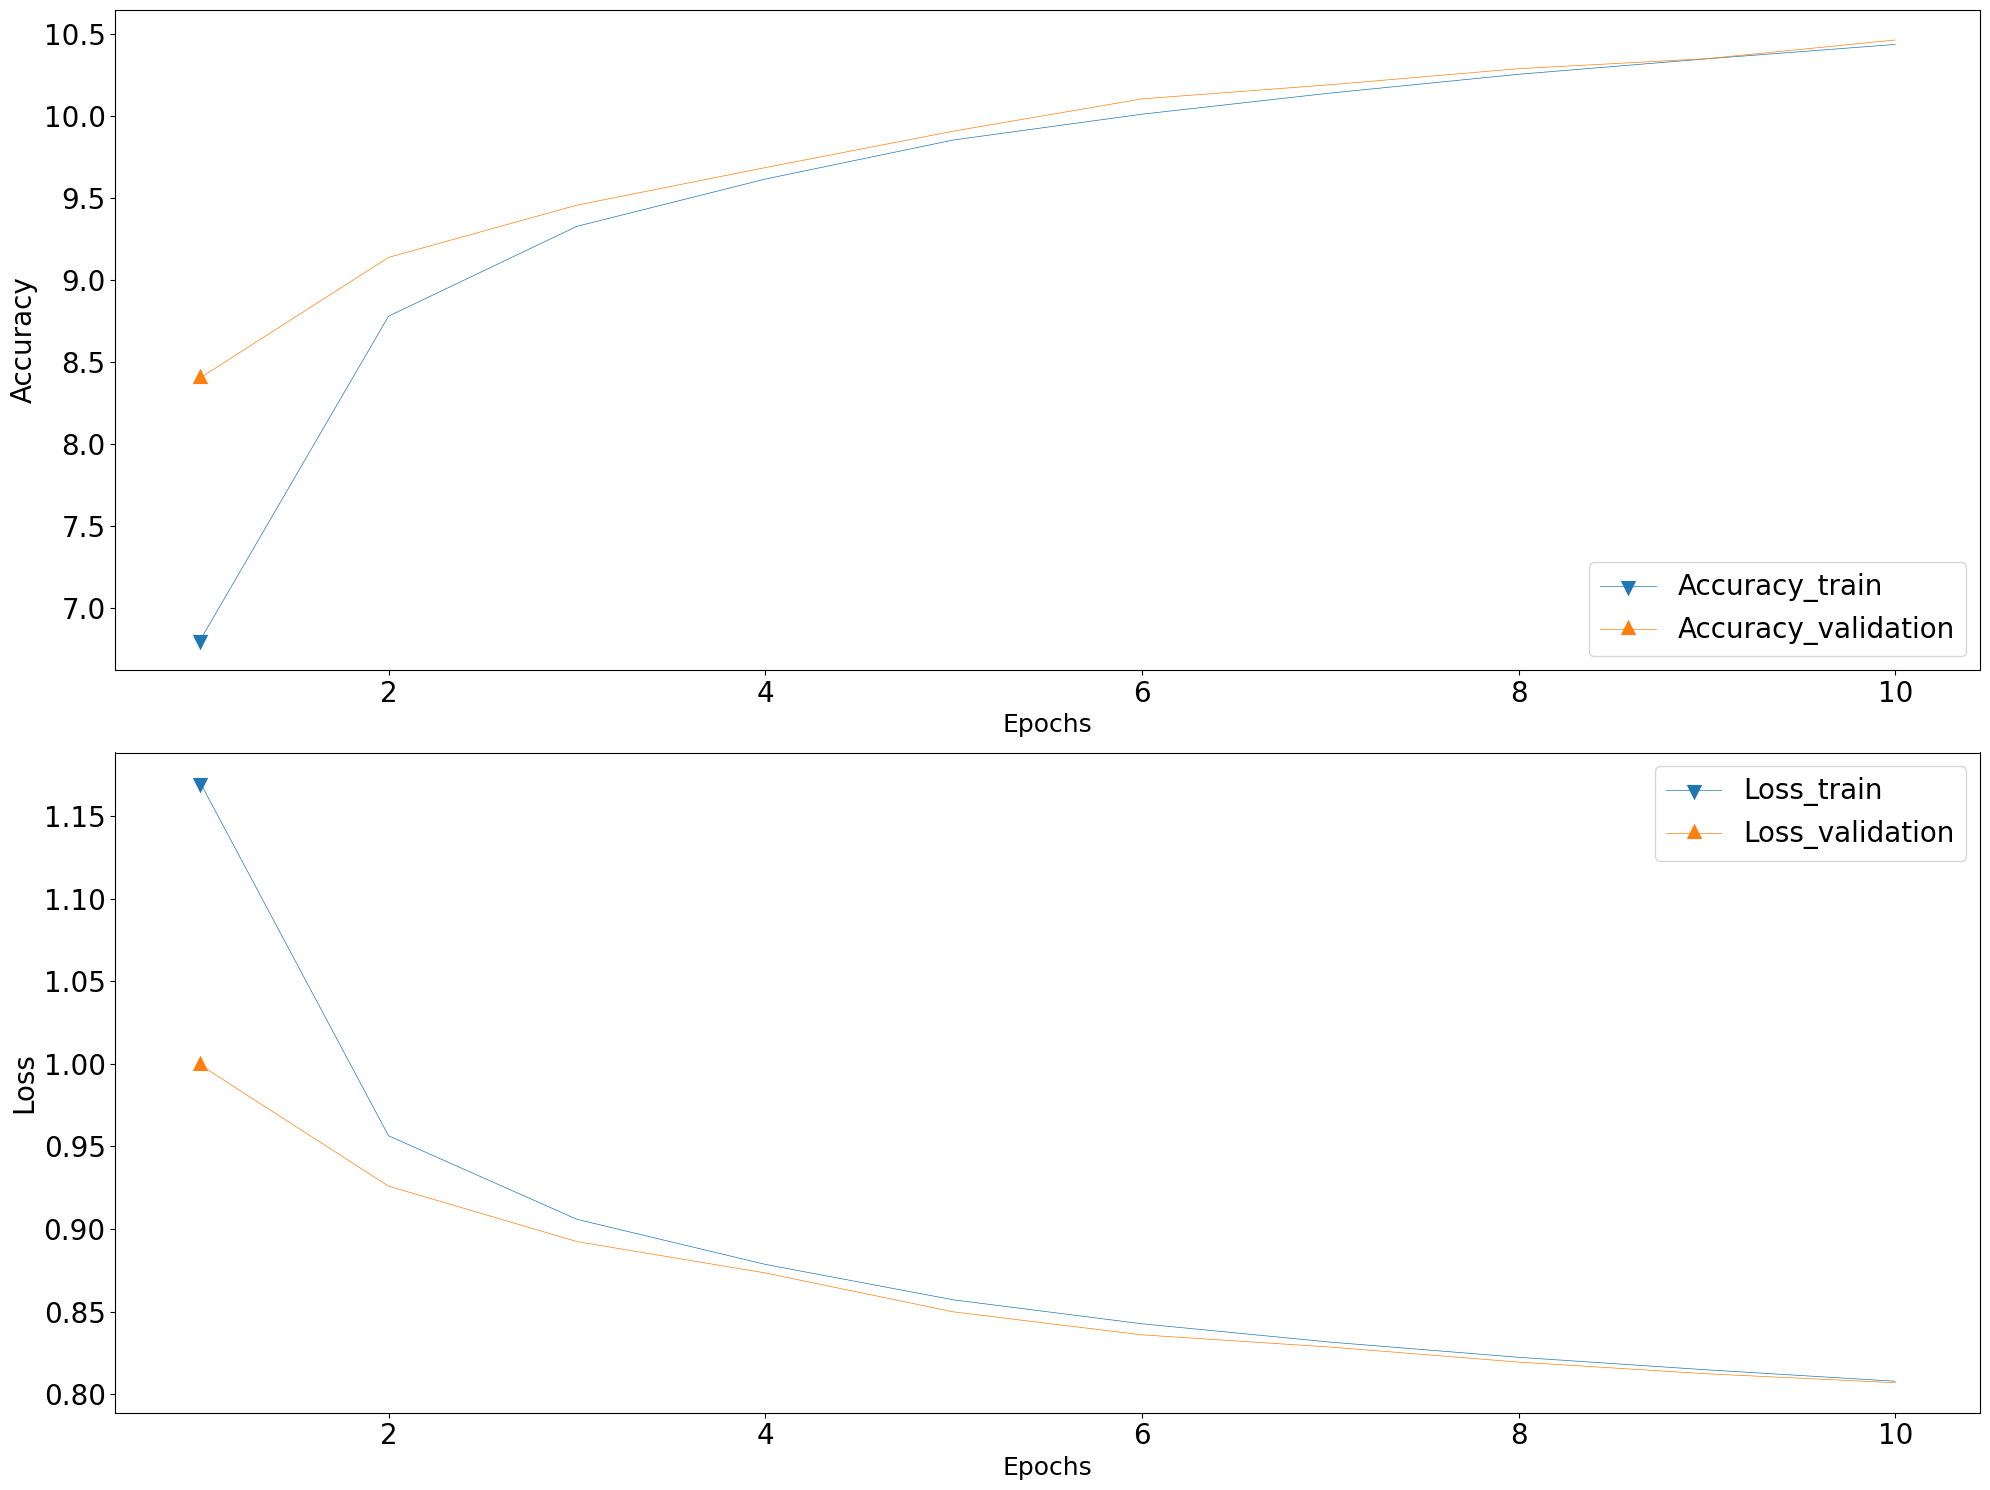

In [7]:
utils.plot_report("1_e_leaky")

### Reconstruction

From the saved models, we can generate reports, to consult the saved models use

In [6]:
# list of saved models
!ls savedModels

model-100epoch_1010_e_leaky.pt	model-500epoch_1010_e_leaky.pt
model-200epoch_1010_e_leaky.pt	model-600epoch_1010_e_leaky.pt
model-300epoch_1010_e_leaky.pt	model-700epoch_1010_e_leaky.pt
model-400epoch_1010_e_leaky.pt	Trained_Machine.pt


In [8]:
%%time
routines.reconstruction(model, "model-100epoch_1010_e_leaky", **parameters)

Preparing data
Load model
Construction latent space
Construction of success each feature
CPU times: user 37min 4s, sys: 8.66 s, total: 37min 13s
Wall time: 6min 20s


In [13]:
%%time
routines.reconstruction(model, "model-700epoch_1010_e_leaky", **parameters)

Preparing data
Load model
Construction latent space
Construction of success each feature
CPU times: user 37min 18s, sys: 8.83 s, total: 37min 27s
Wall time: 6min 27s


### Success by features

In [9]:
!ls success

success_model-100epoch_1010_e_leaky
success_model-best-1_e_leaky
success_model-best-1_e_leaky_to_1_trained_epochs


In [11]:
!head ./success/success_model-best-1_e_leaky_to_1_trained_epochs

13,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1
16,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1
11,1,1,1,1,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,1
6,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1
17,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
14,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1,0,1,1
12,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,0,1,1
5,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
8,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1
6,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1


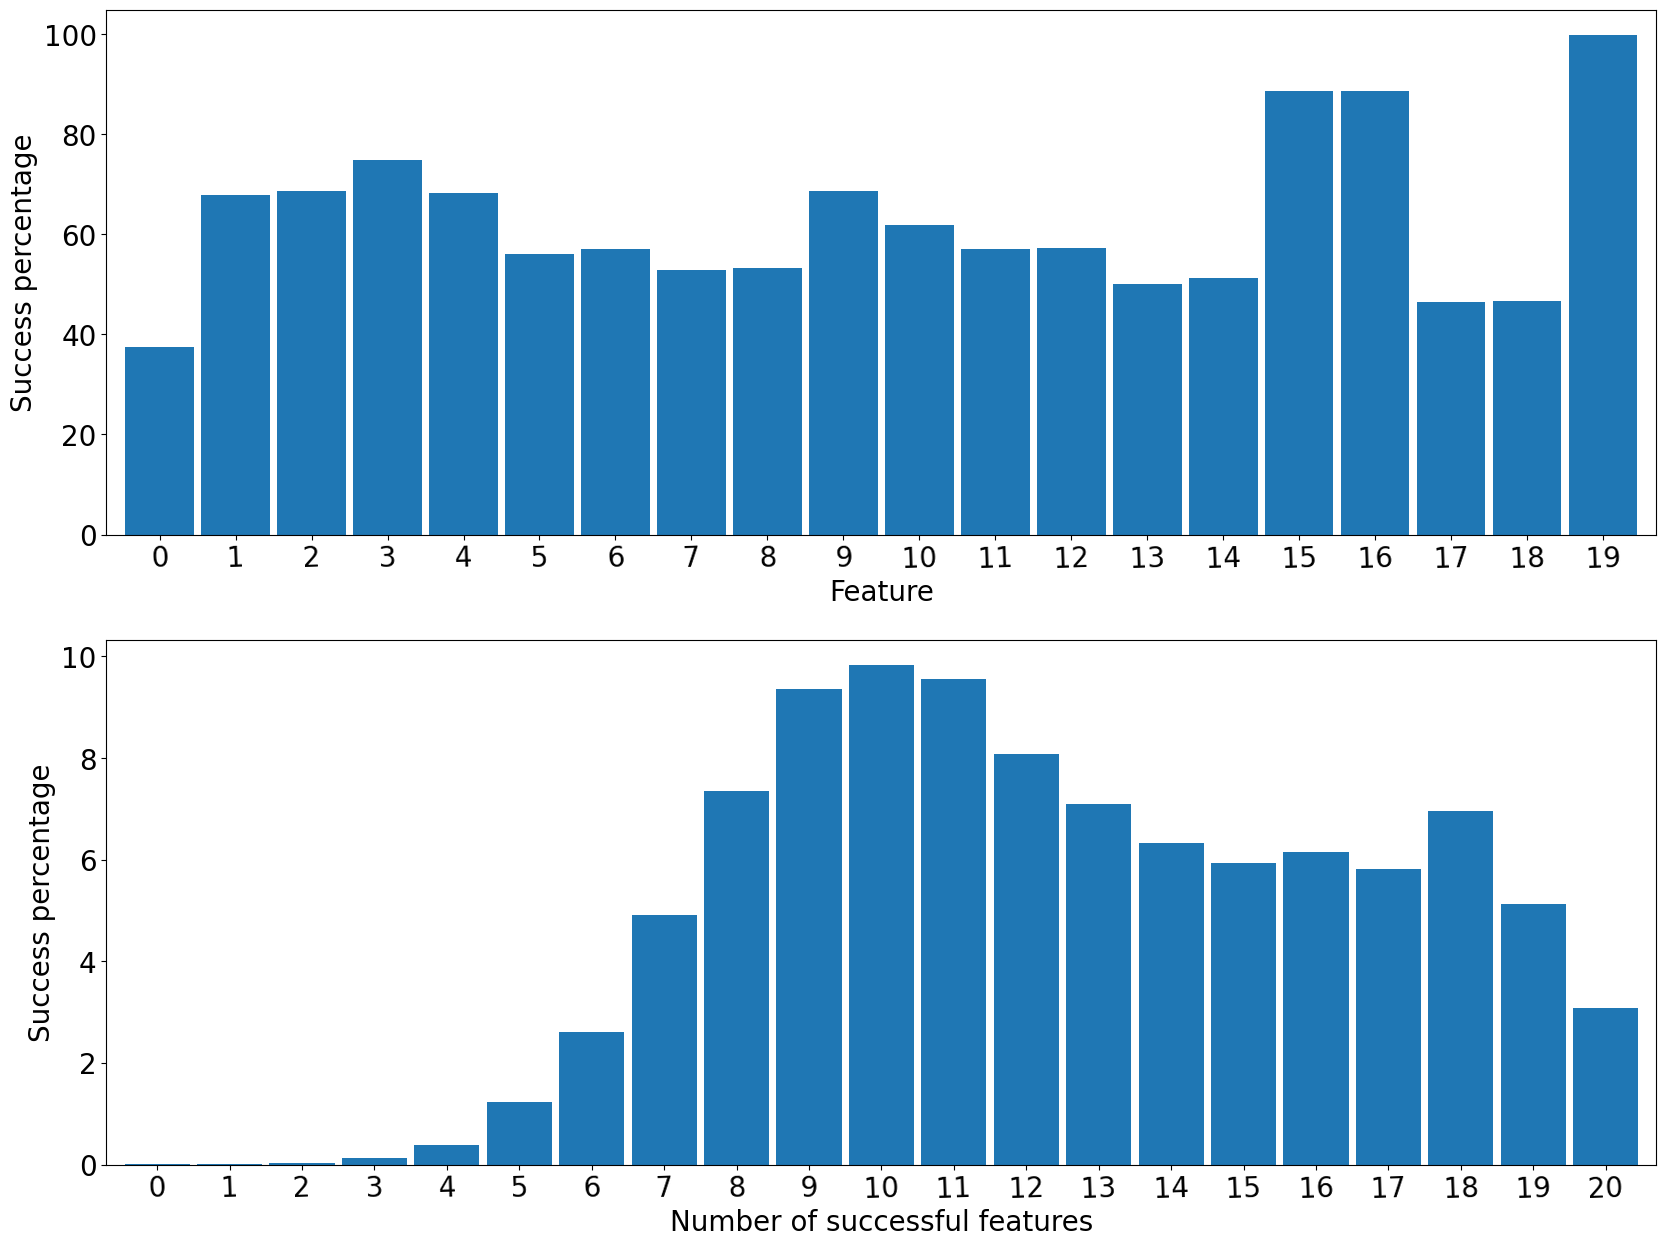

In [10]:
utils.plot_features_statistics("success_model-100epoch_1010_e_leaky")

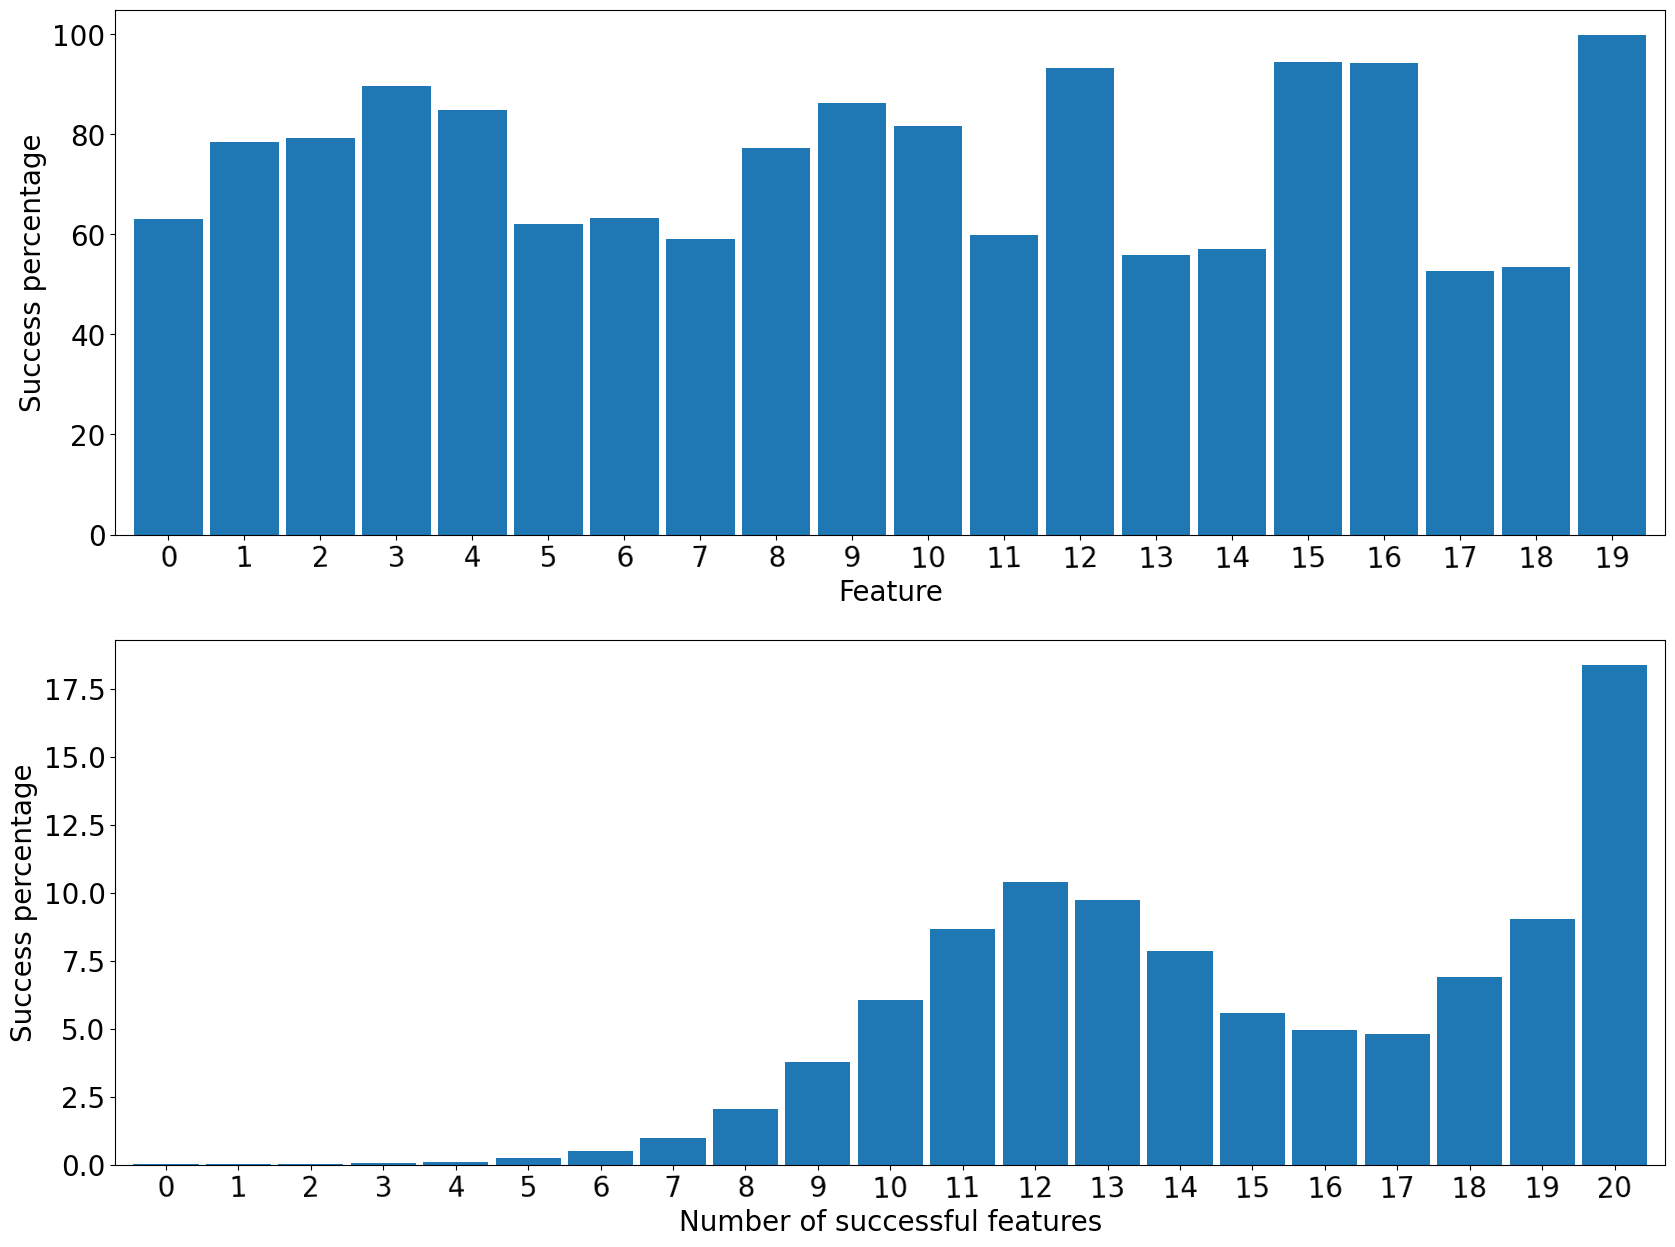

In [14]:
utils.plot_features_statistics("success_model-700epoch_1010_e_leaky")

### Latent space

In [11]:
!ls latentSpaces

latent_z12_model-100epoch_1010_e_leaky
latent_z12_model-best-1_e_leaky
latent_z12_model-best-1_e_leaky_to_1_trained_epochs
latent_z8_model-100epoch_1010_e_leaky
latent_z8_model-best-1_e_leaky
latent_z8_model-best-1_e_leaky_to_1_trained_epochs


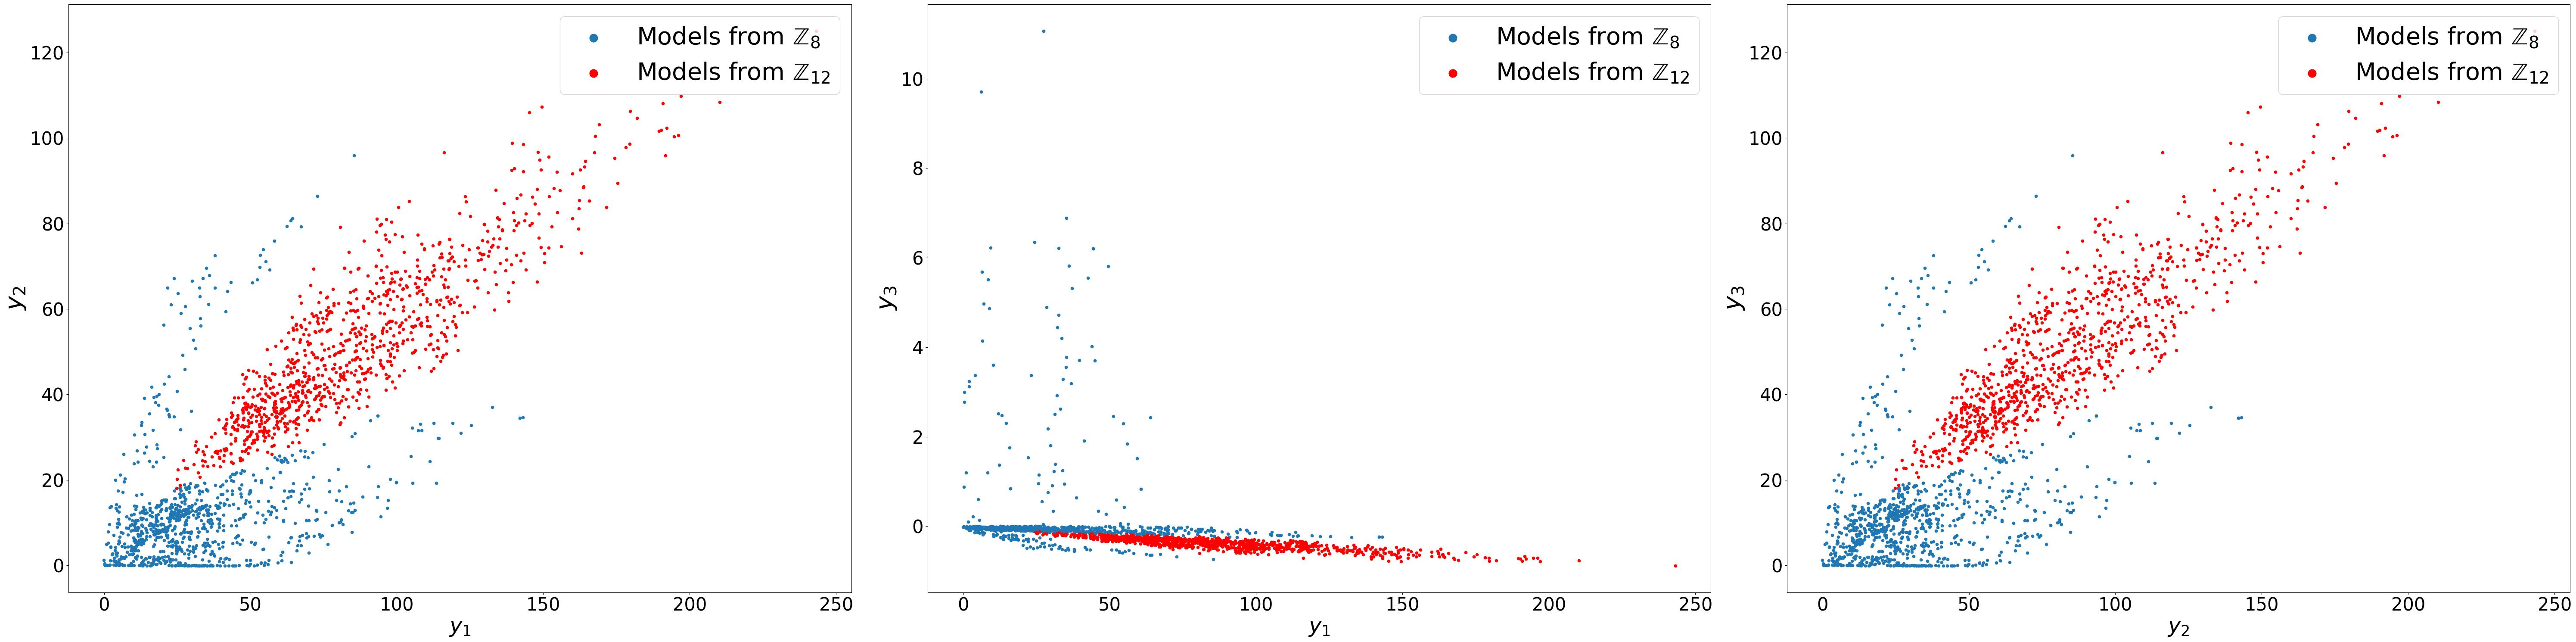

In [19]:
# IMPORTANT: the order must be the same as in the datasetname
utils.plot_2d_latent_space("latent_z8_model-100epoch_1010_e_leaky", "latent_z12_model-100epoch_1010_e_leaky")

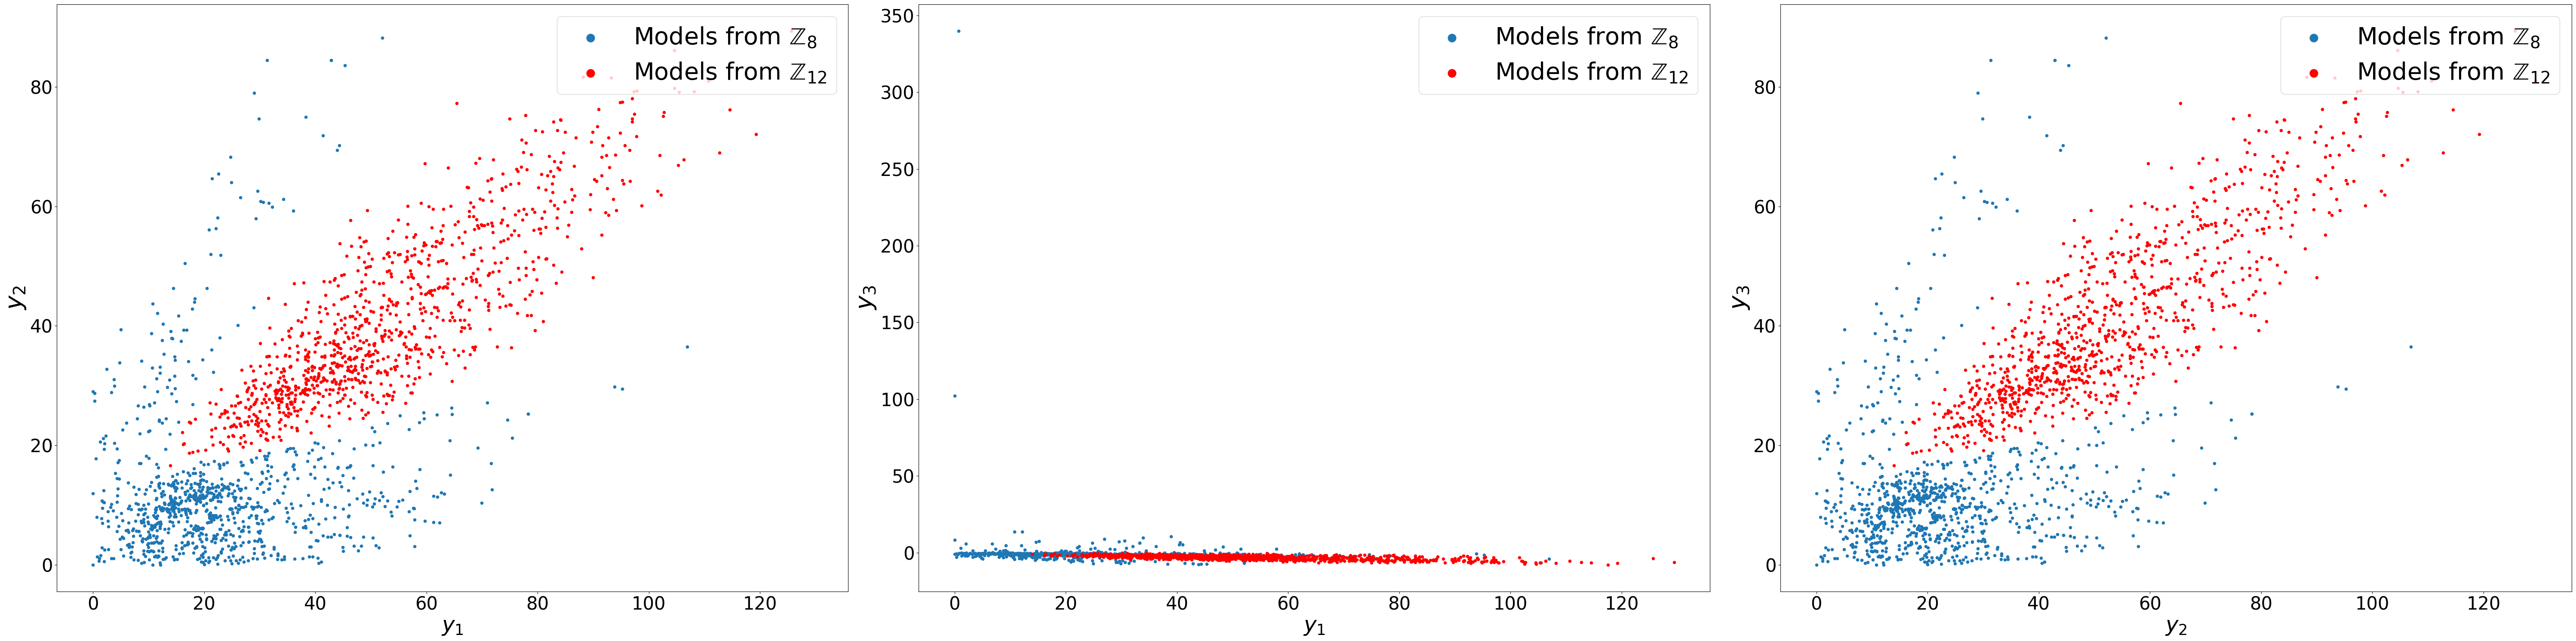

In [20]:
# IMPORTANT: the order must be the same as in the datasetname
utils.plot_2d_latent_space("latent_z8_model-700epoch_1010_e_leaky", "latent_z12_model-700epoch_1010_e_leaky")

### New models

Sometimes it might result useful to load new models and visualize them after being encoded, for example if you
have a trained network, and you want to spot some MSSM models, but they were not included in the dataset during
the training. If that is the case, you can include those files in the data folder and then, by setting the 
parameters exactly as they were during the training you can select one of the saved models, process the new 
data and get quick access to some reports.

In [7]:
!ls data

600K_Z8-Z12.csv		Z12_SU5_100models.csv	Z8_MSSM_176models.txt
Z12_MSSM_554models.txt	Z12_SU5_100models.txt	Z8_SU5_97models.csv
Z12_SM_554models.csv	Z8_MSSM_176modelos.csv	Z8_SU5_97models.txt


In [5]:
# Name other dataset
datasetname_other = './data/Z8_MSSM_176modelos.csv' 
routines.reconstruction_other_models(model, "model-100epoch_1010_e_leaky", datasetname_other,"z8_MSSM", **parameters)

Preparing data
Load model


In [11]:
# Name other dataset
datasetname_other = './data/Z8_MSSM_176modelos.csv' 
routines.reconstruction_other_models(model, "model-700epoch_1010_e_leaky", datasetname_other,"z8_MSSM", **parameters)

Preparing data
Load model


In [6]:
# Name other dataset
datasetname_other = './data/Z12_SM_554models.csv' 
routines.reconstruction_other_models(model, "model-100epoch_1010_e_leaky", datasetname_other,"z12_MSSM", **parameters)

Preparing data
Load model


In [12]:
# Name other dataset
datasetname_other = './data/Z12_SM_554models.csv' 
routines.reconstruction_other_models(model, "model-700epoch_1010_e_leaky", datasetname_other,"z12_MSSM", **parameters)

Preparing data
Load model


In [7]:
!ls latentSpaces

latent_z12_model-100epoch_1010_e_leaky
latent_z12_model-700epoch_1010_e_leaky
latent_z12_MSSM-model-100epoch_1010_e_leaky
latent_z8_model-100epoch_1010_e_leaky
latent_z8_model-700epoch_1010_e_leaky
latent_z8_MSSM-model-100epoch_1010_e_leaky


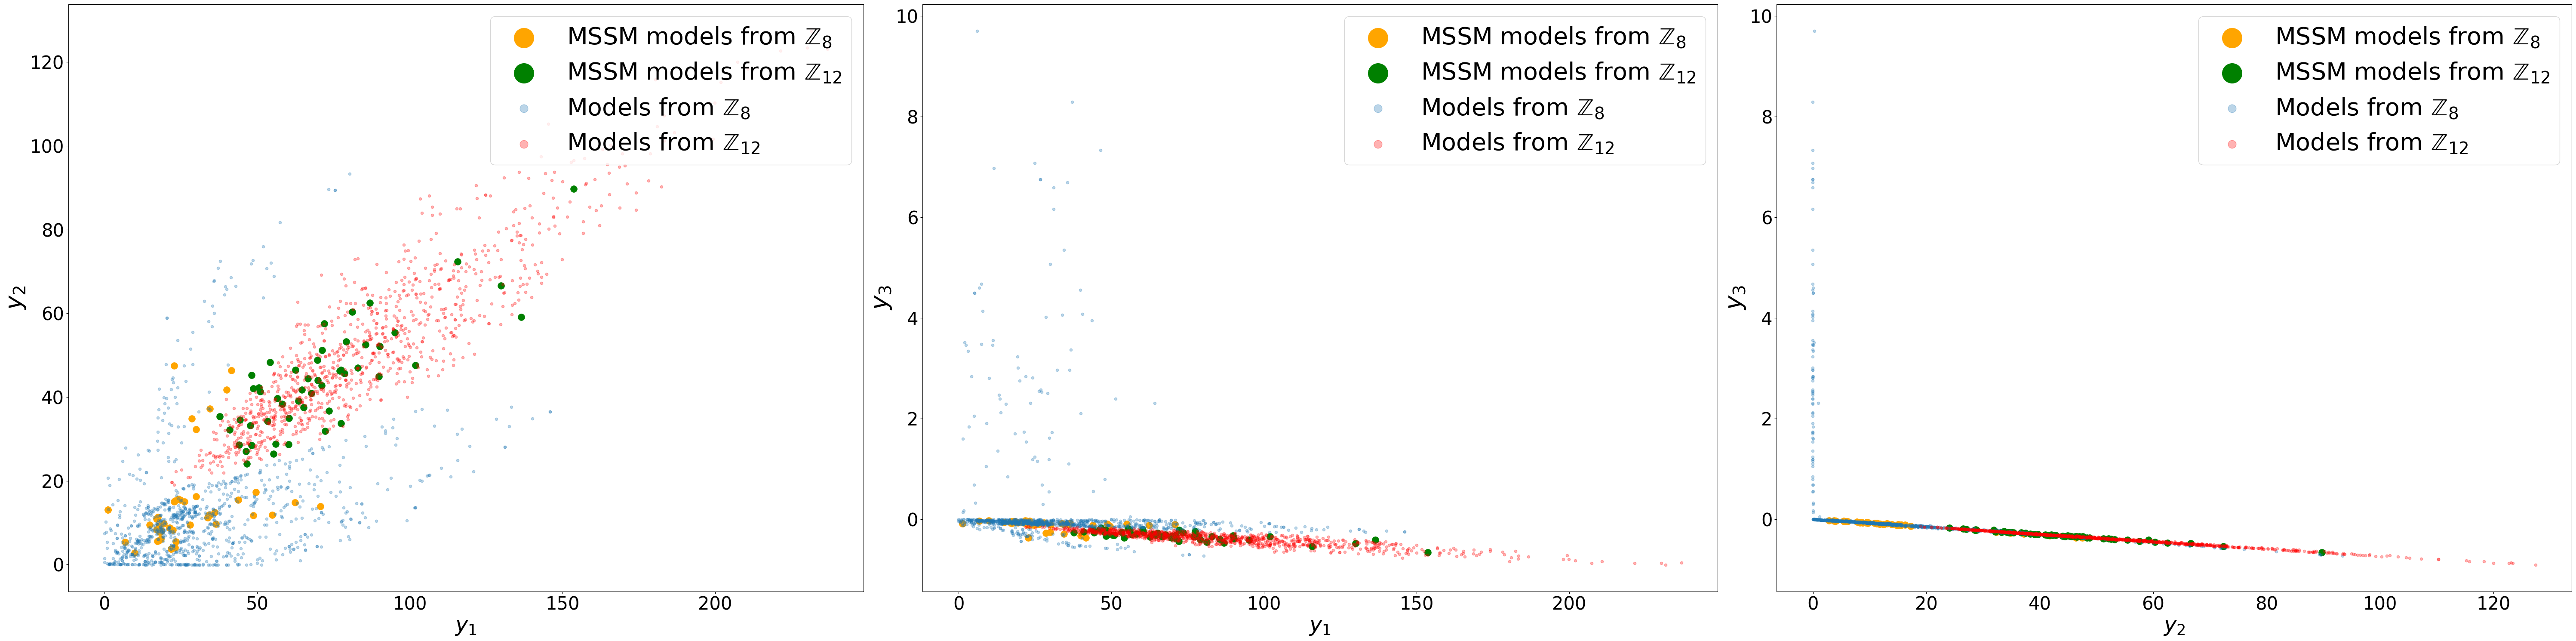

In [18]:
utils.plot_2d_latent_mssm("latent_z8_model-100epoch_1010_e_leaky", "latent_z12_model-100epoch_1010_e_leaky", "latent_z8_MSSM-model-100epoch_1010_e_leaky", "latent_z12_MSSM-model-100epoch_1010_e_leaky")

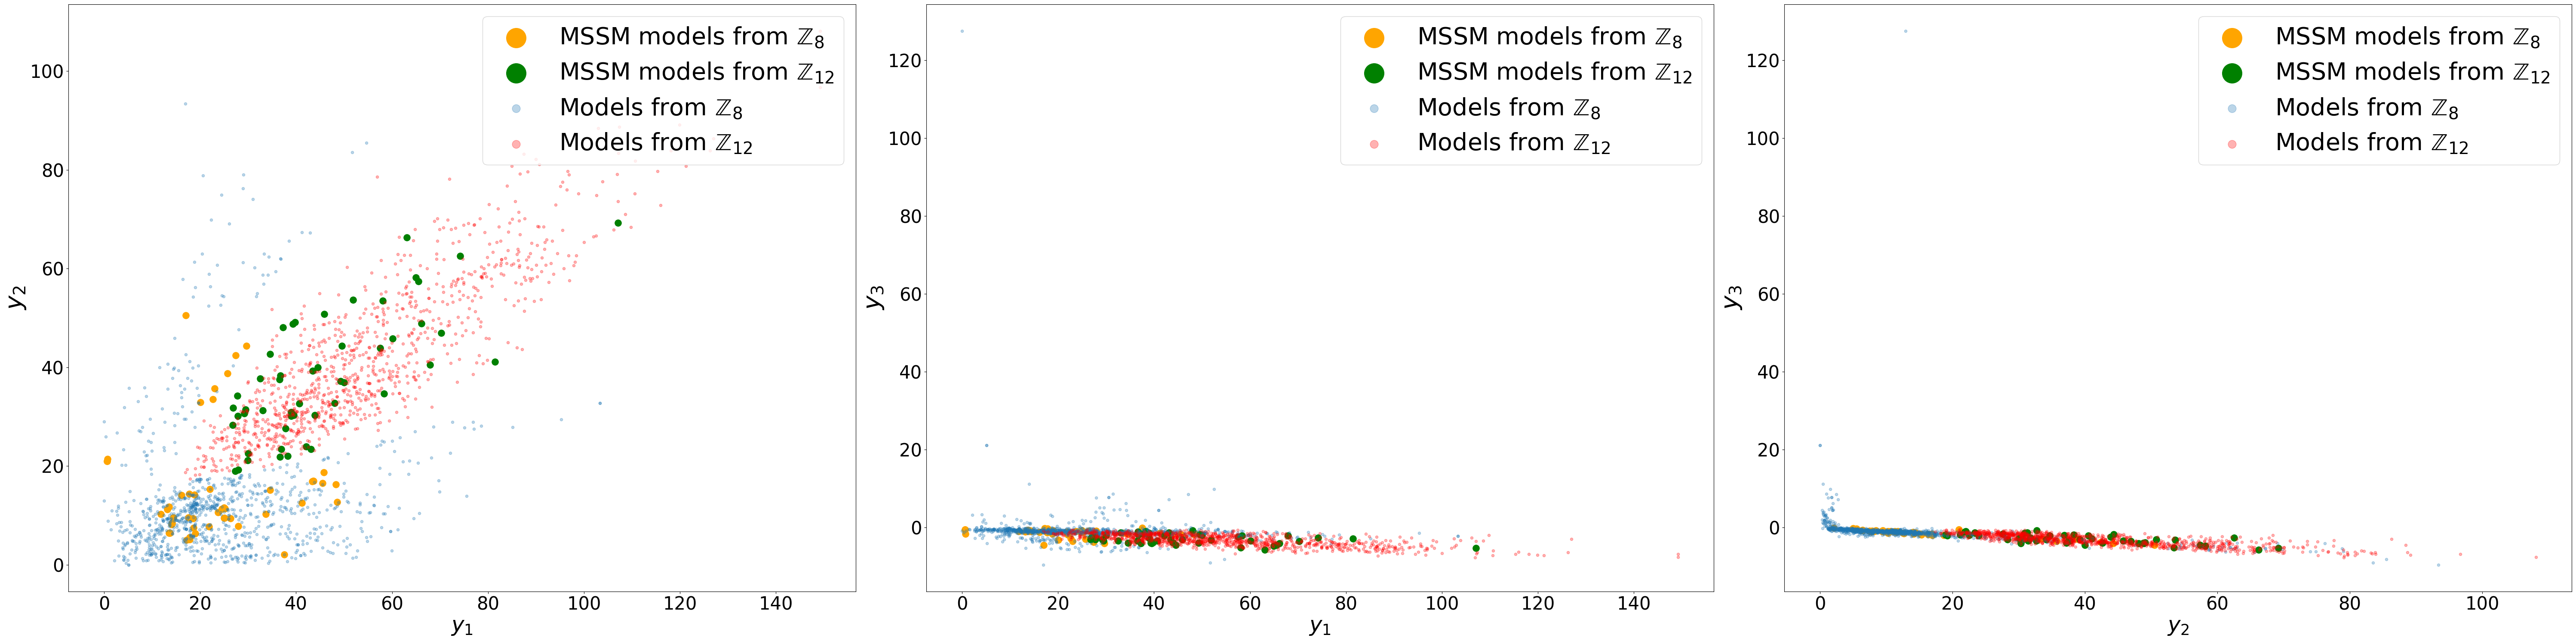

In [13]:
utils.plot_2d_latent_mssm("latent_z8_model-700epoch_1010_e_leaky", "latent_z12_model-700epoch_1010_e_leaky", "latent_z8_MSSM-model-700epoch_1010_e_leaky", "latent_z12_MSSM-model-700epoch_1010_e_leaky")